In [1]:
# Use below code if in the src/ directory
import sys
sys.path.append('data_preprocessing')
import data_preprocessing.normalize as normalize
import data_preprocessing.outliers as outliers
import data_preprocessing.summary as summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.externals import joblib
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split

# Load data

In [2]:
train_data = pd.read_csv('../data/input/ames_train.csv')
test_data = pd.read_csv('../data/input/ames_test.csv')

train_gdata = pd.read_csv('../data/input/ames_geodemo_train.csv')
test_gdata = pd.read_csv('../data/input/ames_geodemo_test.csv')

In [3]:
train_data.set_index('Id', inplace=True)
train_data.drop(['PID'], axis=1, inplace=True)

test_data.set_index('Id', inplace=True)
test_data.drop(['PID'], axis=1, inplace=True)

train_gdata.set_index('Id', inplace=True)
train_gdata.drop(['PID', 'Latitude', 'Longitude', 'county', 'tract', 'blkgrp'], axis=1, inplace=True)

test_gdata.set_index('Id', inplace=True)
test_gdata.drop(['PID', 'Latitude', 'Longitude', 'county', 'tract', 'blkgrp'], axis=1, inplace=True)

In [4]:
train_data = normalize.fill_in_missing_values(train_data)
train_data = outliers.remove_outliers(train_data)
#train_data = normalize.normalize(train_data)

test_data = normalize.fill_in_missing_values(test_data)
test_data = outliers.remove_outliers(test_data)
#test_data = normalize.normalize(test_data)

train_gdata = normalize.fill_in_missing_values(train_gdata)
train_gdata = outliers.remove_outliers(train_gdata)
#train_gdata = normalize.normalize(train_gdata)

test_gdata = normalize.fill_in_missing_values(test_gdata)
test_gdata = outliers.remove_outliers(test_gdata)
#test_gdata = normalize.normalize(test_gdata)

In [5]:
# Remove categorical data
train_data = train_data.select_dtypes(include=[np.number])
test_data = test_data.select_dtypes(include=[np.number])
train_gdata = train_gdata.select_dtypes(include=[np.number])
test_gdata = test_gdata.select_dtypes(include=[np.number])

print(train_data.shape)
print(test_data.shape)
print(train_gdata.shape)
print(test_gdata.shape)

(2306, 37)
(574, 37)
(2306, 78)
(574, 78)


In [6]:
# Split training set into train and validation set
X_train, X_val, y_train, y_val = train_test_split(train_data.loc[:, train_data.columns != 'SalePrice'], 
                                                  train_data['SalePrice'],
                                                  test_size=0.2, random_state=42)

X_train = X_train.values
X_val = X_val.values
y_train = y_train.values
y_val = y_val.values

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1844, 36)
(462, 36)
(1844,)
(462,)


In [7]:
# Split geodemo training set into train and validation set
X_train_geo, X_val_geo, y_train_geo, y_val_geo = train_test_split(train_gdata.loc[:, train_gdata.columns != 'SalePrice'], 
                                                                  train_gdata['SalePrice'],
                                                                  test_size=0.2, random_state=42)

X_train_geo = X_train_geo.values
X_val_geo = X_val_geo.values
y_train_geo = y_train_geo.values
y_val_geo = y_val_geo.values

print(X_train_geo.shape)
print(X_val_geo.shape)
print(y_train_geo.shape)
print(y_val_geo.shape)

(1844, 77)
(462, 77)
(1844,)
(462,)


# Gaussian Process  
http://scikit-learn.org/stable/modules/gaussian_process.html  
http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor  
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html  
https://en.wikipedia.org/wiki/Gaussian_process  

Issue with kernels: https://github.com/scikit-learn/scikit-learn/pull/7385

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, RBF, DotProduct, RationalQuadratic, ConstantKernel as C
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

In [11]:
#kernel = 1.0**2 * Matern(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0), nu=0.5)
#gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=42)
gpr = GaussianProcessRegressor(normalize_y=True, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()), ('gpr', gpr)])

In [90]:
# Hyperparameter tuning

param_grid = [
  {'gpr__kernel': [C(1.0, (1e-3, 1e3)) * RBF(0.1), 
                   C(1.0, (1e-3, 1e3)) * RBF(0.3),
                   C(1.0, (1e-3, 1e3)) * RBF(1.0),
                   C(1.0, (1e-3, 1e3)) * RBF(3.0),
                   C(1.0, (1e-3, 1e3)) * RBF(10.),
                   C(1.0, (1e-3, 1e3)) * Matern(0.1, nu=0.5), 
                   C(1.0, (1e-3, 1e3)) * Matern(0.3, nu=0.5),
                   C(1.0, (1e-3, 1e3)) * Matern(1.0, nu=0.5),
                   C(1.0, (1e-3, 1e3)) * Matern(3.0, nu=0.5),
                   C(1.0, (1e-3, 1e3)) * Matern(10., nu=0.5),
                   C(1.0, (1e-3, 1e3)) * Matern(0.1, nu=1.5), 
                   C(1.0, (1e-3, 1e3)) * Matern(0.3, nu=1.5),
                   C(1.0, (1e-3, 1e3)) * Matern(1.0, nu=1.5),
                   C(1.0, (1e-3, 1e3)) * Matern(3.0, nu=1.5),
                   C(1.0, (1e-3, 1e3)) * Matern(10., nu=1.5),
                   C(1.0, (1e-3, 1e3)) * Matern(0.1, nu=2.5), 
                   C(1.0, (1e-3, 1e3)) * Matern(0.3, nu=2.5),
                   C(1.0, (1e-3, 1e3)) * Matern(1.0, nu=2.5),
                   C(1.0, (1e-3, 1e3)) * Matern(3.0, nu=2.5),
                   C(1.0, (1e-3, 1e3)) * Matern(10., nu=2.5),
                   C(1.0, (1e-3, 1e3)) * DotProduct(0.1), 
                   C(1.0, (1e-3, 1e3)) * DotProduct(0.3),
                   C(1.0, (1e-3, 1e3)) * DotProduct(1.0),
                   C(1.0, (1e-3, 1e3)) * DotProduct(3.0),
                   C(1.0, (1e-3, 1e3)) * DotProduct(10.),
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=1.0, length_scale=0.1), 
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=1.0, length_scale=0.3),
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=1.0, length_scale=1.0),
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=1.0, length_scale=3.0),
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=1.0, length_scale=10.),
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=3.0, length_scale=0.1), 
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=3.0, length_scale=0.3),
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=3.0, length_scale=1.0),
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=3.0, length_scale=3.0),
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=3.0, length_scale=10.),
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=10., length_scale=0.1), 
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=10., length_scale=0.3),
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=10., length_scale=1.0),
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=10., length_scale=3.0),
                   C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=10., length_scale=10.),
                   C(1.0, (1e-3, 1e3)) * WhiteKernel(noise_level=1.0),
                   C(1.0, (1e-3, 1e3)) * WhiteKernel(noise_level=3.0),
                   C(1.0, (1e-3, 1e3)) * WhiteKernel(noise_level=10.)]}
]

gs = GridSearchCV(pipe, param_grid, cv=5,
                   scoring='r2')
gs.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

print("Best parameters set found on development set:")
print()
print(gs.best_params_)
print()
print("Grid scores on development set:")
print()
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -4.85956300e+12,  -1.98406438e+12]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.49578279e+12,  -5.17028223e+11]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -7.03689582e+13,  -7.37013503e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
D:\Prog

D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  1.09116216e+11,   3.45444619e+10]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -2.11106470e+14,  -0.00000000e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.51846142e+13,  -2.38478556e+06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
D:\Prog

D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  1.05552910e+14,  -0.00000000e+00,  -0.00000000e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 86, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.25508554e+12,   1.92319395e+12,  -3.46508538e+12]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -2.11635137e+11,   1.61469216e+10,  -3.80412825e+10]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 8, 'wa

Best parameters set found on development set:

{'gpr__kernel': 1**2 * Matern(length_scale=3, nu=0.5)}

Grid scores on development set:

0.160 (+/-0.639) for {'gpr__kernel': 1**2 * RBF(length_scale=0.1)}
0.160 (+/-0.638) for {'gpr__kernel': 1**2 * RBF(length_scale=0.3)}
0.357 (+/-0.654) for {'gpr__kernel': 1**2 * RBF(length_scale=1)}
-0.000 (+/-0.006) for {'gpr__kernel': 1**2 * RBF(length_scale=3)}
-0.000 (+/-0.006) for {'gpr__kernel': 1**2 * RBF(length_scale=10)}
0.885 (+/-0.059) for {'gpr__kernel': 1**2 * Matern(length_scale=0.1, nu=0.5)}
0.548 (+/-0.892) for {'gpr__kernel': 1**2 * Matern(length_scale=0.3, nu=0.5)}
0.702 (+/-0.701) for {'gpr__kernel': 1**2 * Matern(length_scale=1, nu=0.5)}
0.899 (+/-0.050) for {'gpr__kernel': 1**2 * Matern(length_scale=3, nu=0.5)}
-0.000 (+/-0.006) for {'gpr__kernel': 1**2 * Matern(length_scale=10, nu=0.5)}
0.698 (+/-0.702) for {'gpr__kernel': 1**2 * Matern(length_scale=0.1, nu=1.5)}
0.708 (+/-0.711) for {'gpr__kernel': 1**2 * Matern(length_scale=0.3,

In [102]:
#gpr = GaussianProcessRegressor(kernel=C(1.0, (1e-3, 1e3)) * RationalQuadratic(10.), 
#                               normalize_y=True, random_state=42)
gpr = GaussianProcessRegressor(kernel=C(1.0, (1e-3, 1e3)) * Matern(3.0, nu=0.5), 
                               normalize_y=True, random_state=42)

clf = Pipeline([('scaler', StandardScaler()), ('gpr', gpr)])
clf.fit(X_train, y_train)

y_val_pred = clf.predict(X_val)
y_val_pred = y_val_pred.astype('int')
r2_score(y_val, y_val_pred)
print('R2 score:', np.round(r2_score(y_val, y_val_pred), 4))
print('Median margin of error:', np.median(np.abs((y_val_pred - y_val) / y_val)))

D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


R2 score: 0.91
Median margin of error: 0.0605245042314


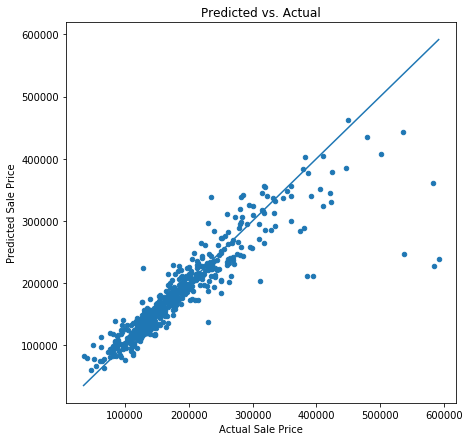

In [93]:
summary.pred_vs_actual_plot(y_test_pred, y_test)

### Geo demo

In [100]:
gpr = GaussianProcessRegressor(kernel=C(1.0, (1e-3, 1e3)) * Matern(3.0, nu=0.5), 
                               normalize_y=True, random_state=42)

clf = Pipeline([('scaler', StandardScaler()), ('gpr', gpr)])
clf.fit(X_train_geo, y_train_geo)

y_val_geo_pred = clf.predict(X_val_geo)
y_val_geo_pred = y_val_geo_pred.astype('int')
print('R2 score:', np.round(r2_score(y_val_geo, y_val_geo_pred), 4))
print('Median margin of error:', np.median(np.abs((y_val_geo_pred - y_val_geo) / y_val_geo)))

D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


R2 score: 0.888
Median margin of error: 0.0574141398515


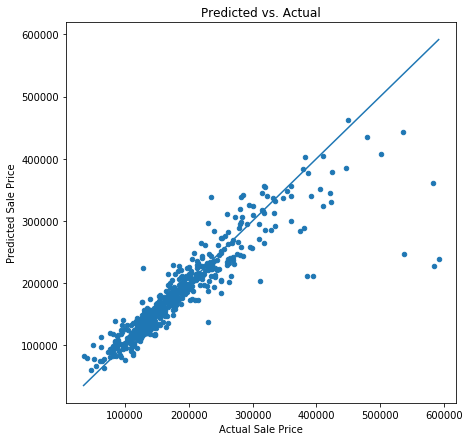

In [101]:
summary.pred_vs_actual_plot(y_test_pred, y_test)

### Subset of features
This section overwrites X_train, X_val, y_train, y_val

In [10]:
# Split training set into train and validation set
X_train, X_val, y_train, y_val = train_test_split(train_data[['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 
                                                              'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 
                                                              'YearBuilt', 'YearRemodAdd']], 
                                                  train_data['SalePrice'],
                                                  test_size=0.2, random_state=42)

X_train = X_train.values
X_val = X_val.values
y_train = y_train.values
y_val = y_val.values

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1844, 10)
(462, 10)
(1844,)
(462,)


In [11]:
gpr = GaussianProcessRegressor(kernel=C(1.0, (1e-3, 1e3)) * Matern(3.0, nu=0.5), 
                               normalize_y=True, random_state=42)

clf = Pipeline([('scaler', StandardScaler()), ('gpr', gpr)])
clf.fit(X_train, y_train)

y_val_pred = clf.predict(X_val)
y_val_pred = y_val_pred.astype('int')
r2_score(y_val, y_val_pred)
print('R2 score:', np.round(r2_score(y_val, y_val_pred), 4))
print('Median margin of error:', np.median(np.abs((y_val_pred - y_val) / y_val)))

D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


R2 score: 0.0239
Median margin of error: 0.273579952336


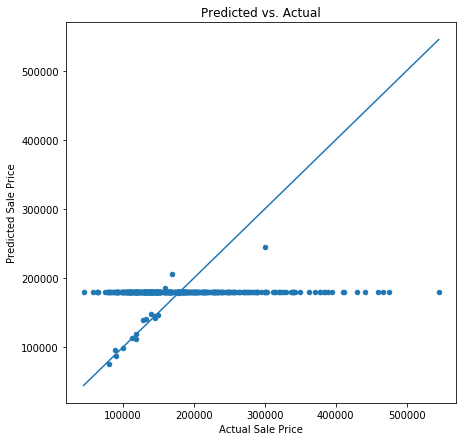

In [13]:
summary.pred_vs_actual_plot(y_val_pred, y_val)

### Prediction exploration

In [95]:
pred_df = pd.DataFrame(data={'actual': y_test, 'predictions': y_test_pred}, index=test_data.index)
pred_df['diff'] = pred_df['predictions'] - pred_df['actual']
pred_df['percent_diff'] = pred_df['diff'] / pred_df['actual']

pred_df['diff_bin'] = pd.cut(pred_df['percent_diff'], 
                             [-np.inf, -0.25, -0.10, -0.05, -0.01, 0.01, 0.05, 0.10, 0.25, np.inf])

print('Median margin of error:', np.median(np.abs(pred_df['percent_diff'])))

Median margin of error: 0.0657155172414


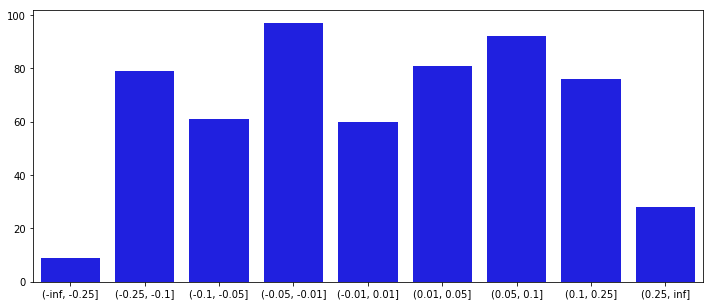

In [97]:
temp = pred_df['diff_bin'].value_counts().sort_values()

plt.figure(figsize=(12, 5))
sns.barplot(temp.index, temp.values, color='b')
plt.show()

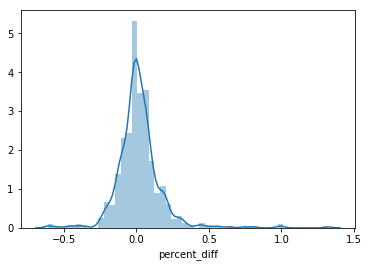

In [98]:
sns.distplot(pred_df['percent_diff'])
plt.show()

# Output results
We want to output models and predictions on the test set with and without geodemos for reporting and comparison

In [10]:
# Test data
X_test = test_data.loc[:, test_data.columns != 'SalePrice']
y_test = test_data['SalePrice']

# Train final model
gpr = GaussianProcessRegressor(kernel=C(1.0, (1e-3, 1e3)) * Matern(3.0, nu=0.5), 
                               normalize_y=True, random_state=42)

clf = Pipeline([('scaler', StandardScaler()), ('gpr', gpr)])
clf.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
pred = clf.predict(X_test)
print('R2 score:', np.round(r2_score(y_test, pred), 4))
print('Median margin of error:', np.median(np.abs((pred - y_test) / y_test)))

# Output predictions
pred_df = pd.DataFrame(data={'predictions': pred}, index=test_data.index)
pred_df.to_csv('../data/output/pred_gaussian_process.csv')

# Pickle final model
joblib.dump(clf, '../models/model_gaussian_process.pkl')# Output results

D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -2.69327165e+15,   1.81281681e+13]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 33, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)


R2 score: 0.918
Median margin of error: 0.0584145378434


['../models/model_gaussian_process.pkl']

In [12]:
# Test data with geodemos
X_test_geo = test_gdata.loc[:, test_gdata.columns != 'SalePrice']
y_test_geo = test_gdata['SalePrice']

# Train final model
gpr = GaussianProcessRegressor(kernel=C(1.0, (1e-3, 1e3)) * Matern(3.0, nu=0.5), 
                               normalize_y=True, random_state=42)

clf = Pipeline([('scaler', StandardScaler()), ('gpr', gpr)])
clf.fit(np.concatenate((X_train_geo, X_val_geo)), np.concatenate((y_train_geo, y_val_geo)))
pred = clf.predict(X_test_geo)
print('R2 score:', np.round(r2_score(y_test_geo, pred), 4))
print('Median margin of error:', np.median(np.abs((pred - y_test_geo) / y_test_geo)))

# Output predictions
pred_df = pd.DataFrame(data={'predictions': pred}, index=test_gdata.index)
pred_df.to_csv('../data/output/pred_gaussian_process_geo.csv')

# Pickle final model
joblib.dump(clf, '../models/model_gaussian_process_geo.pkl')

D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -2.21060168e+15,   1.33544656e+13]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 22, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)


R2 score: 0.9238
Median margin of error: 0.0524115981469


['../models/model_gaussian_process_geo.pkl']